# UFO Sighthings  

Se provee una base de datos que contiene avistamientos de ovnis en años pasados. Se pide Responder algunas preguntas respecto a estos avistamientos:   
1. ¿Dónde dirías que es más probable tener avistamientos ovnis?
2. ¿Observas algún tipo de patrón en los avistamientos a lo largo del tiempo? ¿Crees que exista alguna estacionalidad en los eventos?
3. ¿Qué correlaciones encuentras con los lugares donde hubo avistamientos?
4. ¿En general, cómo se ve los ovnis que se describen en los avistamientos?



## Análisis Exploratorio de Datos

In [87]:
# Lectura del file
import pandas as pd
import csv

ufo_raw = pd.read_csv("Business case/UFO_sightings.csv",
                        sep=",",
                        quotechar='"',
                        dtype=str,
                        engine="python",
                        on_bad_lines="skip"
    )

ufo_raw.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.9411111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.6458333
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.8036111


In [88]:
ufo_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88679 entries, 0 to 88678
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   datetime              88679 non-null  object
 1   city                  88679 non-null  object
 2   state                 81270 non-null  object
 3   country               76314 non-null  object
 4   shape                 85757 non-null  object
 5   duration (seconds)    88677 non-null  object
 6   duration (hours/min)  85660 non-null  object
 7   comments              88644 non-null  object
 8   date posted           88679 non-null  object
 9   latitude              88679 non-null  object
 10  longitude             88679 non-null  object
dtypes: object(11)
memory usage: 7.4+ MB


### Revisión de la temporalidad

In [89]:
# Limpieza de las variables
df_ufo = ufo_raw.copy() # Trabajar un df nuevo con los ajustes y preservar el original.
# Convertir columnas 'datetime' y 'date posted' al tipo datetime
df_ufo["datetime"] = pd.to_datetime(df_ufo["datetime"], errors="coerce")
df_ufo["date posted"] = pd.to_datetime(df_ufo["date posted"], errors="coerce")
# Crear columna con año-mes
df_ufo["year_month"] = df_ufo["datetime"].dt.to_period("M").astype(str)
# Conteo por año-mes
conteo_mensual = df_ufo["year_month"].value_counts().sort_index()

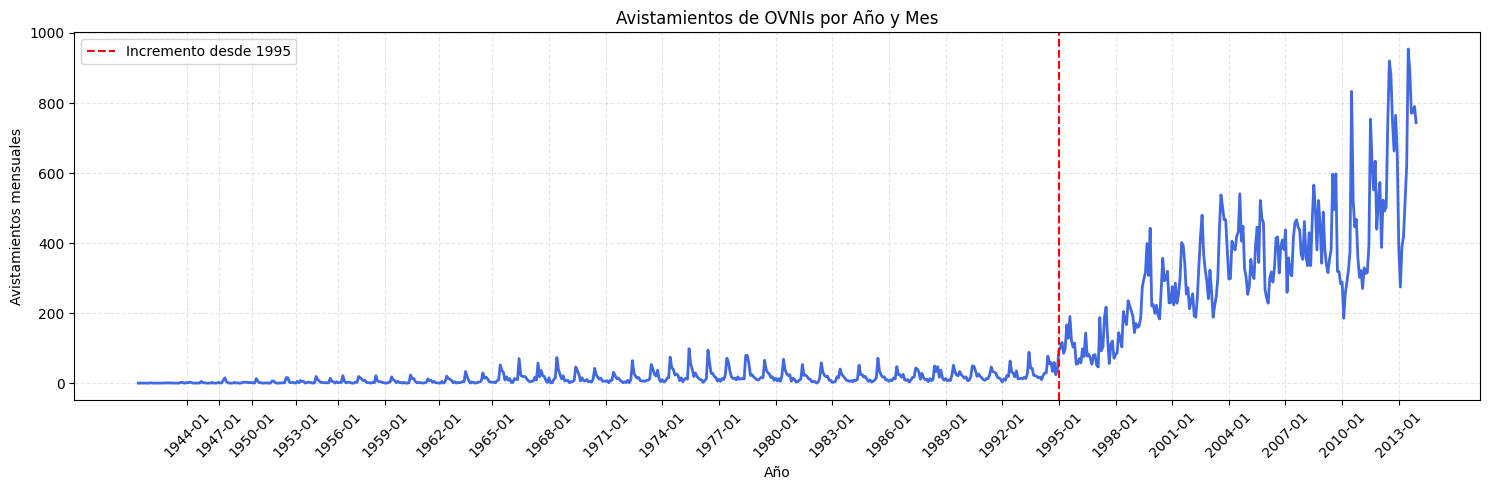

In [93]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Trabajamos hasta data 2013, ya que 2014 esta incompleto.
df_temp = df_ufo[df_ufo["datetime"].dt.year <= 2013].copy() 
df_temp["year_month"] = df_temp["datetime"].dt.to_period("M").astype(str) # Crear columna año-mes


conteo_mensual = df_temp["year_month"].value_counts().sort_index() # Conteo por año-mes
fechas = pd.to_datetime(conteo_mensual.index, format="%Y-%m") # Convertir a datetime para formatear ejes

plt.figure(figsize=(15, 5))
plt.plot(conteo_mensual.index, conteo_mensual.values, color="royalblue", linewidth=2)
plt.axvline("1995-01", color="red", linestyle="--", linewidth=1.5, label="Incremento desde 1995")
plt.xlabel("Año")
plt.ylabel("Avistamientos mensuales")
plt.title("Avistamientos de OVNIs por Año y Mes")
xticks_filtered = [x for x in conteo_mensual.index if x.endswith('-01') and int(x[:4]) % 3 == 0] # Mostrar solo cada 5 años
plt.xticks(xticks_filtered, rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("imagenes/Serie de tiempo-Mes-Año.png", dpi=300, bbox_inches='tight')

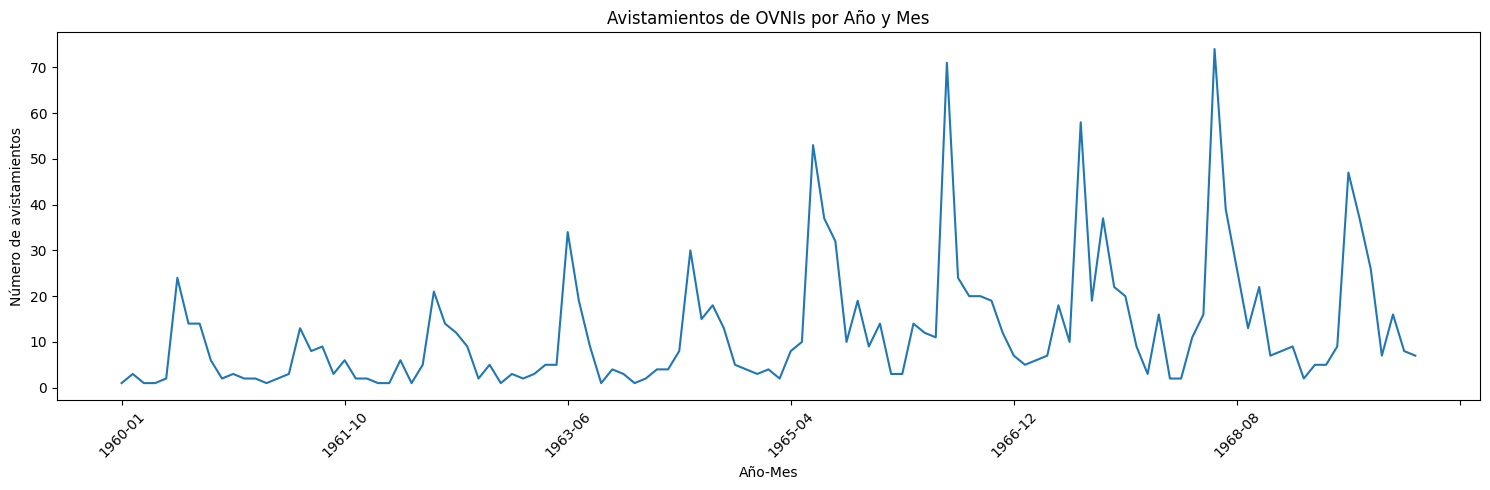

In [92]:
# Filtrar el rango entre 1900 y 1950 para ver mas clara la estacionalidad
conteo_mensual_filtrado = conteo_mensual[
    (conteo_mensual.index >= "1960") & (conteo_mensual.index <= "1970")
]
plt.figure(figsize=(15, 5))
conteo_mensual_filtrado.plot(kind="line")
plt.xlabel("Año-Mes")
plt.ylabel("Número de avistamientos")
plt.title("Avistamientos de OVNIs por Año y Mes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

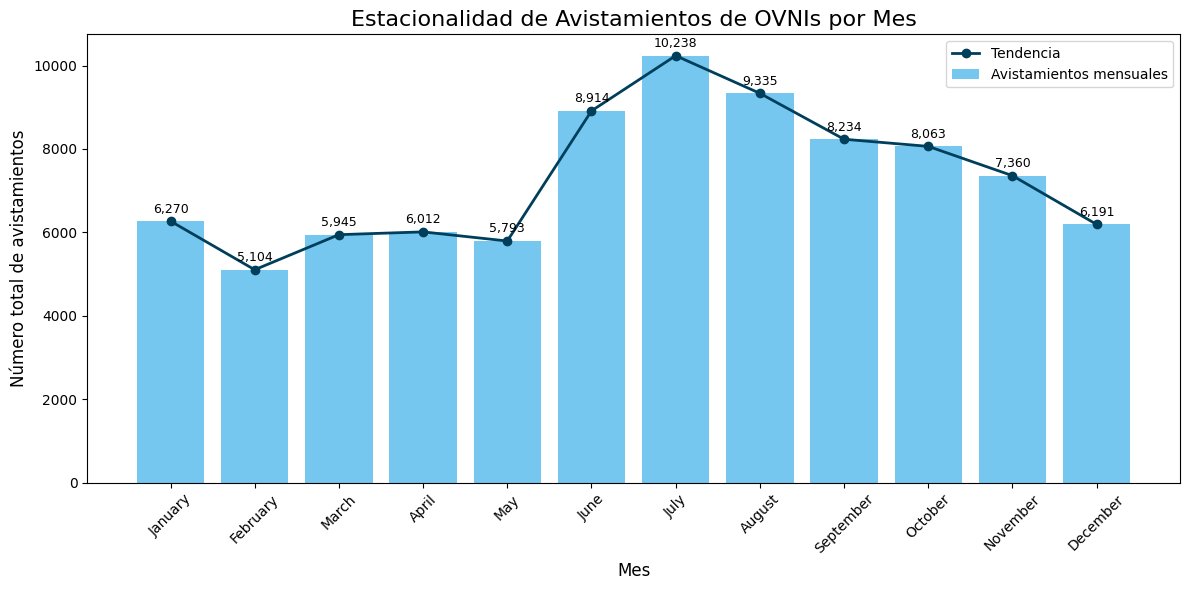

In [112]:
import matplotlib.pyplot as plt

df_ufo["month_name"] = df_ufo["datetime"].dt.month_name()
order = ['January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December']

# Conteo de avistamientos por mes
conteo_mensual = df_ufo["month_name"].value_counts().reindex(order)


plt.figure(figsize=(12, 6))
bars = plt.bar(conteo_mensual.index, conteo_mensual.values, color="#76c7f0", label="Avistamientos mensuales") 
plt.plot(conteo_mensual.index, conteo_mensual.values, color="#003f5c", marker="o", linewidth=2, label="Tendencia") 
for i, value in enumerate(conteo_mensual.values):
    plt.text(i, value + max(conteo_mensual.values)*0.02, f"{value:,}", ha='center', fontsize=9)

plt.title("Estacionalidad de Avistamientos de OVNIs por Mes", fontsize=16)
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Número total de avistamientos", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("imagenes/grafico_estacionalidad_ovnis_mensual.png", dpi=300, bbox_inches='tight')
plt.show()

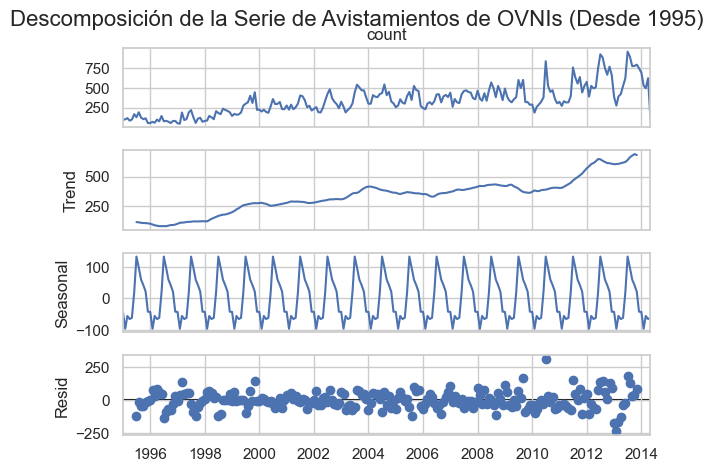

In [161]:
# Analisis de serie de tiempo descritivo

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas as pd

df_decomp = df_ufo[df_ufo["datetime"].dt.year >= 1995].copy() # Filtrar desde 1995 que empieza mas evidente

# Crear serie de tiempo mensual
series_monthly = df_decomp["datetime"].dt.to_period("M").value_counts().sort_index()
series_monthly.index = pd.to_datetime(series_monthly.index.astype(str))
series_monthly = series_monthly.asfreq("MS").fillna(0)  # Asegurar frecuencia mensual y rellenar vacíos con 0


result = seasonal_decompose(series_monthly, model='additive') # Descomposición estacional


fig = result.plot()
fig.suptitle("Descomposición de la Serie de Avistamientos de OVNIs (Desde 1995)", fontsize=16)
plt.subplots_adjust(top=0.90)
plt.show()

In [162]:
# Prueba de Anova
import pandas as pd
from scipy.stats import f_oneway

# --- Configuración temporal: usar rango confiable de datos ---
# A partir de 1995, cuando el volumen empieza a ser representativo
df_anova = df_ufo[df_ufo["datetime"].dt.year >= 1995].copy()

df_anova["year"] = df_anova["datetime"].dt.year
df_anova["month"] = df_anova["datetime"].dt.month


counts_year_month = (
    df_anova.groupby(["year", "month"])
    .size()
    .unstack("month")
    .sort_index()
)
month_groups = [counts_year_month[m].dropna().values for m in counts_year_month.columns]
f_stat, p_value = f_oneway(*month_groups)
print(f"F = {f_stat:.2f}, p = {p_value:.4e}")

F = 3.24, p = 4.0304e-04


### Revisión de la ubicación

In [95]:
df_ufo["latitude"] = pd.to_numeric(df_ufo["latitude"], errors="coerce")
df_ufo["longitude"] = pd.to_numeric(df_ufo["longitude"], errors="coerce")

In [98]:
# Cantidad de faltantes
df_ufo[["country", "state", "city", "latitude", "longitude"]].isna().sum()

country      12365
state         7409
city             0
latitude         1
longitude        0
dtype: int64

In [163]:
# Country valores
df_country_counts = df_ufo['country'].value_counts(dropna=False).reset_index()
df_country_counts['Pct'] = round(df_country_counts['count']/df_country_counts['count'].sum()*100, 2)
df_country_counts

,country,count,Pct
0,us,70293,79.27
1,NaN,12365,13.94
2,ca,3266,3.68
3,gb,2050,2.31
4,au,593,0.67
5,de,112,0.13


In [164]:
print("Cantidad de Avistamientos con un Pais declarado en el set de datos:", df_ufo['country'].value_counts().sum())

Cantidad de Avistamientos con un Pais declarado en el set de datos: 76314


In [165]:
# Donde la longitued es diferente de 0 y el country es nulo
df_ufo[(df_ufo['longitude'] != '0') & (df_ufo['country'].isnull())].shape

(12365, 23)

In [166]:
import reverse_geocoder as rg
import pycountry
import numpy as np

# Crear máscara para coordenadas válidas (no nulas y diferentes de 0)
mask_valid_coords = (
    df_ufo["latitude"].notna() &
    df_ufo["longitude"].notna() &
    (df_ufo["latitude"] != 0) &
    (df_ufo["longitude"] != 0)
)

# Lista de coordenadas válidas
coordenadas = list(zip(df_ufo.loc[mask_valid_coords, "latitude"], df_ufo.loc[mask_valid_coords, "longitude"]))

# Aplicar reverse geocoding solo a las coordenadas válidas
resultados = rg.search(coordenadas, mode=2)

# Inicializar columnas con NaN
columnas_nuevas = ["lat_guess", "lon_guess", "city_guess", "admin1_guess", "admin2_guess", 
                    "country_code_guess", "country_name_guess"]
for col in columnas_nuevas:
    df_ufo[col] = pd.Series([np.nan] * len(df_ufo), dtype="object")

# Asignar resultados solo a las filas válidas
df_ufo.loc[mask_valid_coords, "lat_guess"] = [r["lat"] for r in resultados]
df_ufo.loc[mask_valid_coords, "lon_guess"] = [r["lon"] for r in resultados]
df_ufo.loc[mask_valid_coords, "city_guess"] = [r["name"] for r in resultados]
df_ufo.loc[mask_valid_coords, "admin1_guess"] = [r["admin1"] for r in resultados]
df_ufo.loc[mask_valid_coords, "admin2_guess"] = [r["admin2"] for r in resultados]
df_ufo.loc[mask_valid_coords, "country_code_guess"] = [r["cc"] for r in resultados]

# Convertir código ISO a nombre de país
def iso_to_country_name(code):
    try:
        return pycountry.countries.get(alpha_2=code.upper()).name
    except:
        return None

df_ufo.loc[mask_valid_coords, "country_name_guess"] = df_ufo.loc[mask_valid_coords, "country_code_guess"].apply(iso_to_country_name)

In [167]:
# Revisando la información previa de country para US con los nuevos valores obtenidos por coordenadas
df_ufo[df_ufo['country'] == 'us']['country_name_guess'].value_counts(dropna=False)

country_name_guess
United States         70243
Puerto Rico              26
Canada                   16
Mexico                    5
Russian Federation        3
Name: count, dtype: int64

In [168]:
ufo_country = df_ufo['country_code_guess'].value_counts().reset_index()
ufo_country.columns = ["País", "Avistamientos"]
ufo_country.head()

,País,Avistamientos
0,US,76742
1,CA,3927
2,GB,2581
3,AU,698
4,MX,260


In [169]:
print('Cantidad de Avistamientos con un Pais asignado en el set de datos:', df_ufo['country_name_guess'].value_counts().sum())

Cantidad de Avistamientos con un Pais asignado en el set de datos: 87174


Con el objetivo de completar los valores faltantes en la variable country, se utilizó la librería reverse_geocoder, que permite asignar país, estado y ciudad estimados a partir de coordenadas geográficas. Este proceso se aplicó exclusivamente a los registros con coordenadas válidas, es decir, aquellos donde tanto latitude como longitude:
* No eran nulos (NaN), y
* No eran iguales a 0 (ya que este valor representa datos no informativos y podría inducir a errores en la geolocalización).

Gracias a esta estrategia, se logró aumentar la cobertura de la columna country, pasando de 76,314 valores declarados originalmente a 87,174 valores asignados, lo que representa una mejora del 14.2% en la completitud de esta característica.

Este enriquecimiento resulta clave para análisis geográficos posteriores y se llevó a cabo de forma local, eficiente y sin requerimientos de conexión a APIs externas.


In [159]:
import plotly.express as px

# Calcular total para el porcentaje
ufo_country["%"] = ufo_country["Avistamientos"] / ufo_country["Avistamientos"].sum()

# Formateo de texto"
ufo_country["label"] = ufo_country.apply(
    lambda row: f"{row['País']}<br>{row['Avistamientos']:,} ({row['%']:.1%})", axis=1
)

# Graficar el treemap
fig = px.treemap(
    ufo_country,
    path=["label"],
    values="Avistamientos",
    title="Distribución de avistamientos de OVNIs por país",
    color="Avistamientos",
    color_continuous_scale="Blues"
)
fig.show()

fig.write_image("imagenes/treemap_ufo_avistamientos.png", scale=2, width=1200, height=800)


In [108]:
ufo_country['%'] = round(ufo_country['%']*100, 2)
ufo_country.head(10)

,País,Avistamientos,%,label
0,US,76742,0.880230,"US<br>76,742 (88.0%)"
1,CA,3927,0.045043,"CA<br>3,927 (4.5%)"
2,GB,2581,0.029604,"GB<br>2,581 (3.0%)"
3,AU,698,0.008006,AU<br>698 (0.8%)
4,MX,260,0.002982,MX<br>260 (0.3%)
5,IN,252,0.002890,IN<br>252 (0.3%)
6,DE,149,0.001709,DE<br>149 (0.2%)
7,NL,119,0.001365,NL<br>119 (0.1%)
8,BR,119,0.001365,BR<br>119 (0.1%)
9,NZ,112,0.001285,NZ<br>112 (0.1%)


In [109]:
# Porcentaje que representa el resto de paises not top 3
ufo_country[~ufo_country['País'].isin(['US', 'CA', 'GB'])]['%'].sum()

np.float64(0.04512295834097999)

In [110]:
# Diccionario de nombre completo a abreviación de estado
us_state_to_code = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE',
    'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
    'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
    'Washington, D.C.': 'DC'
}

df_ufo["state_name_abrev"] = df_ufo.apply(
    lambda row: us_state_to_code.get(row["admin1_guess"]) if row["country_code_guess"] == "US" else None,
    axis=1
)

In [111]:
import plotly.express as px
import plotly.graph_objects as go

# Agrupar y calcular porcentaje
ufo_state_counts = df_ufo[df_ufo['country_code_guess'] == 'US']['state_name_abrev'].value_counts().reset_index()
ufo_state_counts.columns = ['state_name_abrev', 'Avistamientos']
total_us = ufo_state_counts['Avistamientos'].sum()
ufo_state_counts['pct'] = ufo_state_counts['Avistamientos'] / total_us
ufo_state_counts['label_pct'] = (ufo_state_counts['pct'] * 100).round(1).astype(str) + '%'

# Crear mapa coroplético
fig = px.choropleth(
    ufo_state_counts,
    locations="state_name_abrev",
    locationmode="USA-states",
    color="Avistamientos",
    scope="usa",
    color_continuous_scale="Blues",
    hover_name="state_name_abrev",
    hover_data=['Avistamientos', 'pct']  # solo referencias, sin funciones
)

# Agregar porcentajes como anotaciones (Scattergeo)
state_coords = {
    'CA': [-119.4179, 36.7783],
    'TX': [-99.9018, 31.9686],
    'FL': [-81.5158, 27.6648],
    'NY': [-75.4999, 43.0000],
    'WA': [-118.7401, 47.9511],
    # Agrega más si necesitas precisión por estado
}

for _, row in ufo_state_counts.iterrows():
    abbr = row['state_name_abrev']
    if abbr in state_coords:
        lon, lat = state_coords[abbr]
        fig.add_trace(go.Scattergeo(
            lon=[lon],
            lat=[lat],
            text=row['label_pct'],
            mode='text',
            textfont=dict(size=9, color="white", ),
            showlegend=False,
            geo='geo'
        ))

# Layout
fig.update_layout(
    title={
        'text': "Avistamientos de OVNIs en EE.UU. por Estado<br><sup>Color por número de avistamientos. Porcentaje mostrado sobre cada estado</sup>",
        'x': 0.5
    },
    geo=dict(
        scope='usa',
        bgcolor="#b3d1ff",  # fondo tipo mar
        lakecolor="#cce5ff",
        landcolor="white",
        showlakes=True
    ),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

fig.show()
fig.write_image("imagenes/ufo_heatmap_porcentaje.png", scale=2, width=1200, height=800)

In [126]:
df_ufo[['datetime', 'shape', 'duration (seconds)',
    'duration (hours/min)', 'comments', 'latitude',
    'longitude', 'year_month', 'city_guess', 'admin1_guess', 'admin2_guess', 'country_code_guess',
    'country_name_guess', 'state_name_abrev', 'month_name']].to_csv('df_ufo.csv')

### Correlaciones

In [136]:
df_ufo[df_ufo['country_code_guess'] == 'US']['admin1_guess'].value_counts().reset_index().to_clipboard()

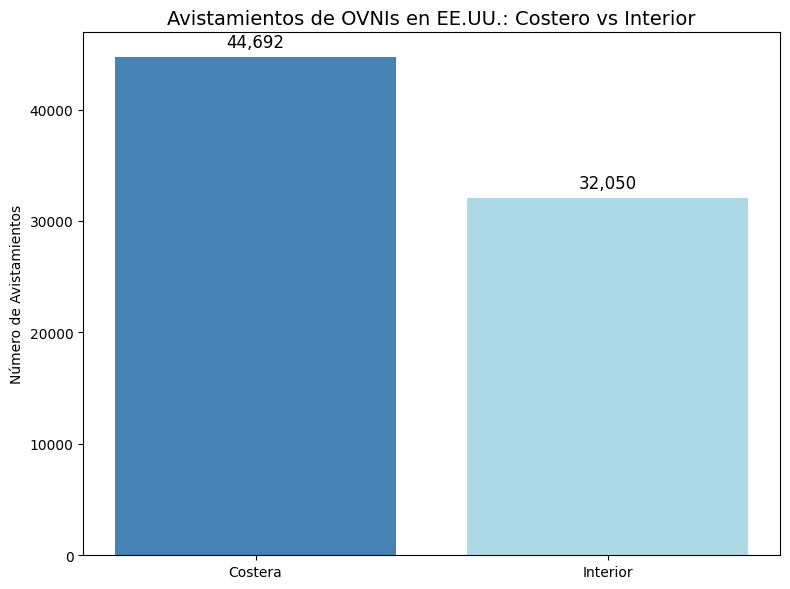

In [129]:
# Lista de estados costeros en EE.UU.
estados_costeros = [
    'California', 'Oregon', 'Washington', 'Florida', 'Georgia', 'South Carolina', 'North Carolina',
    'Virginia', 'Maryland', 'Delaware', 'New Jersey', 'New York', 'Connecticut', 'Rhode Island',
    'Massachusetts', 'New Hampshire', 'Maine', 'Texas', 'Alabama', 'Mississippi', 'Louisiana', 'Alaska',
    'Hawaii'
]

# Clasificación nueva
df_ufo["region_us"] = df_ufo["admin1_guess"].apply(
    lambda x: "Costera" if x in estados_costeros else ("Interior" if pd.notna(x) else None)
)

# Filtrar solo EE.UU.
mask_us = df_ufo["country_code_guess"] == "US"
conteo_region = df_ufo[mask_us & df_ufo["region_us"].notna()]["region_us"].value_counts()

# Gráfico
plt.figure(figsize=(8, 6))
bars = plt.bar(conteo_region.index, conteo_region.values, color=["steelblue", "lightblue"])
for i, value in enumerate(conteo_region.values):
    plt.text(i, value + max(conteo_region.values)*0.02, f"{value:,}", ha='center', fontsize=12)

plt.title("Avistamientos de OVNIs en EE.UU.: Costero vs Interior", fontsize=14)
plt.ylabel("Número de Avistamientos")
plt.tight_layout()
plt.savefig("imagenes/bar_ovnis_costero_interior.png", dpi=300)
plt.show()

In [149]:
population_usa = pd.read_csv('US_Population2024.csv')
population_usa.columns = ['state', 'population']
df_count_state = df_ufo[df_ufo['country_code_guess'] == 'US']['admin1_guess'].value_counts().reset_index()
df_count_state.columns = ['state', 'avistamientos']
df_count_state = df_count_state.merge(population_usa, how='left', on='state')

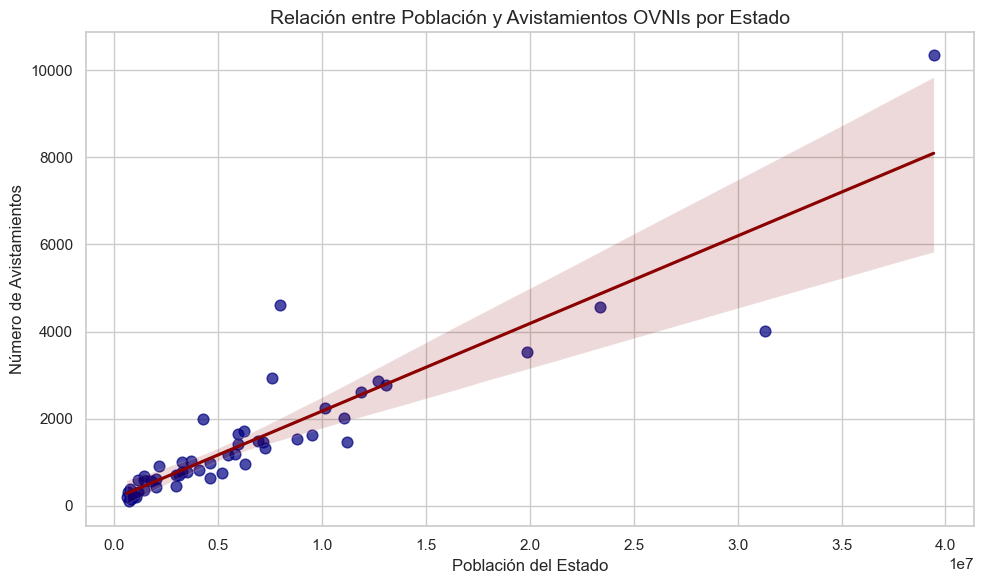

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general
sns.set_theme(style="whitegrid")

# Crear gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.regplot(data=df_count_state, x='population', y='avistamientos', scatter_kws={'s': 60, 'alpha': 0.7}, color="navy", line_kws={"color": "darkred"})

plt.title("Relación entre Población y Avistamientos OVNIs por Estado", fontsize=14)
plt.xlabel("Población del Estado", fontsize=12)
plt.ylabel("Número de Avistamientos", fontsize=12)
plt.tight_layout()

# Guardar imagen
plt.savefig("imagenes/scatter_poblacion_avistamientos.png", dpi=300)
plt.show()

In [170]:
from scipy.stats import pearsonr

# Calcular coeficiente de correlación de Pearson
corr, pval = pearsonr(df_count_state['population'], df_count_state['avistamientos'])

print(f"Coeficiente de correlación (Pearson): {corr:.2f}")
print(f"Valor p: {pval:.4f}")

Coeficiente de correlación (Pearson): 0.91
Valor p: 0.0000


### Forma de los avistamientos

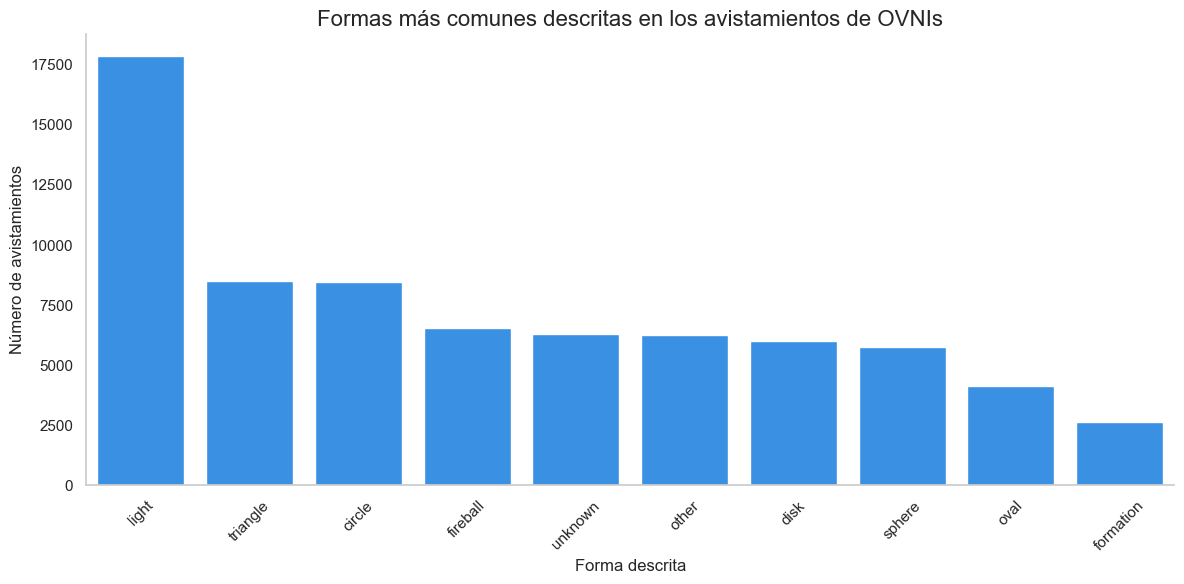

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear conteo de formas más comunes
conteo_formas = df_ufo['shape'].value_counts().head(10)

# Crear gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x=conteo_formas.index, y=conteo_formas.values, color='dodgerblue')

# Ajustes estéticos
plt.title('Formas más comunes descritas en los avistamientos de OVNIs', fontsize=16)
plt.xlabel('Forma descrita', fontsize=12)
plt.ylabel('Número de avistamientos', fontsize=12)
plt.xticks(rotation=45)
sns.despine()  # Elimina los bordes superior y derecho
plt.grid(False)  # Quita las líneas de fondo

# Guardar imagen
plt.tight_layout()
plt.savefig("imagenes/ovnis_formas_mas_comunes.png", dpi=300)
plt.show()